# Quantitative Investing Final Project Code

###  By: Gabriel Owens, Yuan-Cheng Tsai

In [1]:
#Import all packages
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf
pd.options.mode.chained_assignment = None
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from sklearn.model_selection import GridSearchCV
sns.set()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

## Stock Trading using Multiple Technical Indicators 

In [2]:
#Obtain a list of Nasdaq-100 company tickers from Wikipedia 
df=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]
tickers = df.Ticker.to_list()

#Get data from Yahoo Finance for each ticker
stocks = pd.DataFrame()
data = pd.DataFrame()

for i in tickers:
        data = pdr.get_data_yahoo(i, start = dt.datetime(2000,1,1), end = dt.date.today())
        data['ticker'] = i
        stocks = stocks.append(data)

#Create a complete dataframe with all info
stocks['returns'] = stocks.groupby('ticker')['Adj Close'].pct_change()        
stocks.head()

,High,Low,Open,Close,Volume,Adj Close,ticker,returns
Date,,,,,,,,
2000-01-03,1.375000,1.166667,1.312500,1.369792,7226400.0,1.214421,ATVI,NaN
2000-01-04,1.354167,1.187500,1.343750,1.328125,4262400.0,1.177480,ATVI,-0.030418
2000-01-05,1.364583,1.312500,1.317708,1.333333,3390000.0,1.182098,ATVI,0.003921
2000-01-06,1.333333,1.296875,1.322917,1.307292,2430000.0,1.159010,ATVI,-0.019531
2000-01-07,1.354167,1.291667,1.322917,1.343750,15549600.0,1.191333,ATVI,0.027888


# All Indicators Below

In [3]:
#For all strategy "position" columns (1=buy, 0=hold, -1=sell)

## Simple Moving Average (Price)

In [4]:
#Short term window Moving Avg (1 trading week)
stocks['SMA_5'] = stocks.groupby('ticker')['Adj Close'].transform(lambda x: x.rolling(window = 5).mean())
#Long term window Moving Avg (1 trading month)
stocks['SMA_20'] = stocks.groupby('ticker')['Adj Close'].transform(lambda x: x.rolling(window = 20).mean())
#Check for Golden Cross (when short term moving average crosses above long term), aka: when the ratio < 1
stocks['SMA_Ratio'] = stocks['SMA_20'] / stocks['SMA_5']

#Strategy:
#If SMA_Ratio < 1 THEN BUY

#Create a position column where (1=buy, 0=hold, -1=sell)
stocks['SMA_Indicator_Action'] = np.where(stocks['SMA_Ratio'] < 1, 1.0,0.0)
stocks['SMA_Indicator_Position'] = stocks['SMA_Indicator_Action'].diff()

### Example Plot

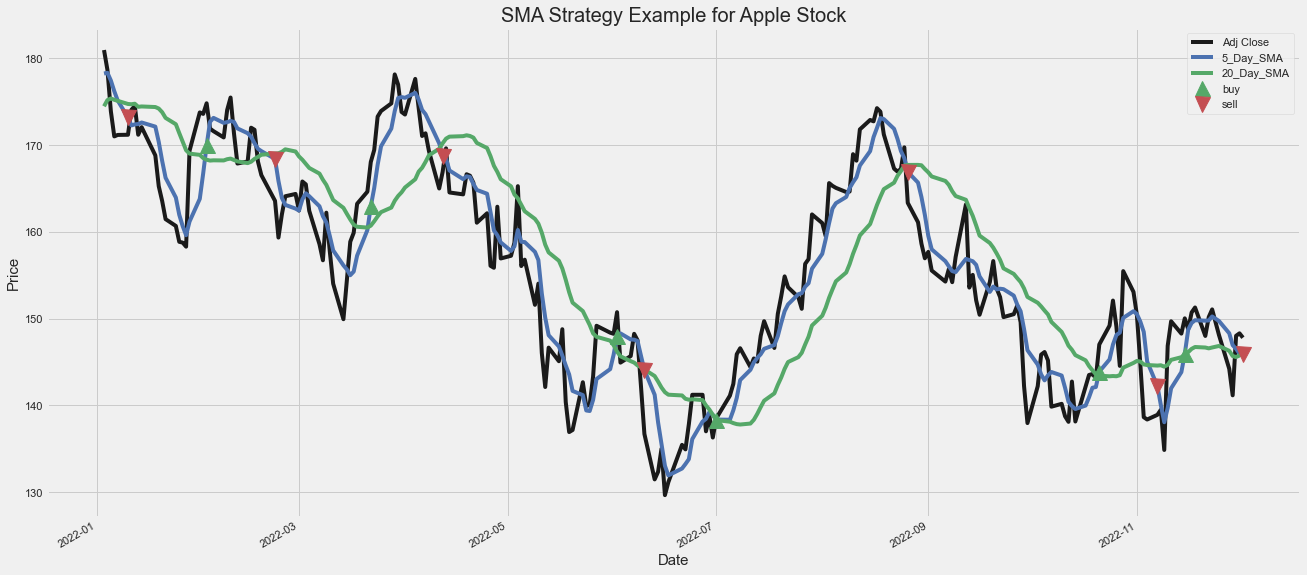

In [5]:
aapl = stocks[stocks['ticker'] == 'AAPL']
aapl = aapl[aapl.index > '2022-01-01']
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
aapl['Adj Close'].plot(color = 'k', label= 'Adj Close') 
aapl['SMA_5'].plot(color = 'b',label = '5_Day_SMA') 
aapl['SMA_20'].plot(color = 'g', label = '20_Day_SMA')
# plot buy signals
plt.plot(aapl[aapl['SMA_Indicator_Position'] == 1].index, 
         aapl['SMA_5'][aapl['SMA_Indicator_Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot sell signals
plt.plot(aapl[aapl['SMA_Indicator_Position'] == -1].index, 
         aapl['SMA_5'][aapl['SMA_Indicator_Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('SMA Strategy Example for Apple Stock', fontsize = 20)
plt.legend()
plt.show()

## Simple Moving Average (Volume)

In [6]:
#Short term window Moving Avg (1 trading week)
stocks['SMA_Volume_5'] = stocks.groupby('ticker')['Volume'].transform(lambda x: x.rolling(window = 5).mean())
#Long term window Moving Avg (1 trading month)
stocks['SMA_Volume_20'] = stocks.groupby('ticker')['Volume'].transform(lambda x: x.rolling(window = 20).mean())
#Check for Golden Cross (when short term moving average crosses above long term), aka: when the ratio < 1
stocks['SMA_Volume_Ratio'] = stocks['SMA_Volume_20'] / stocks['SMA_Volume_5']

#Strategy:
#If SMA_Volume_Ratio < 1 THEN BUY
stocks['SMA_Vol_Indicator_Action'] = np.where(stocks['SMA_Volume_Ratio'] < 1, 1.0,0.0)
stocks['SMA_Vol_Indicator_Position'] = stocks['SMA_Vol_Indicator_Action'].diff()

### Example Plot

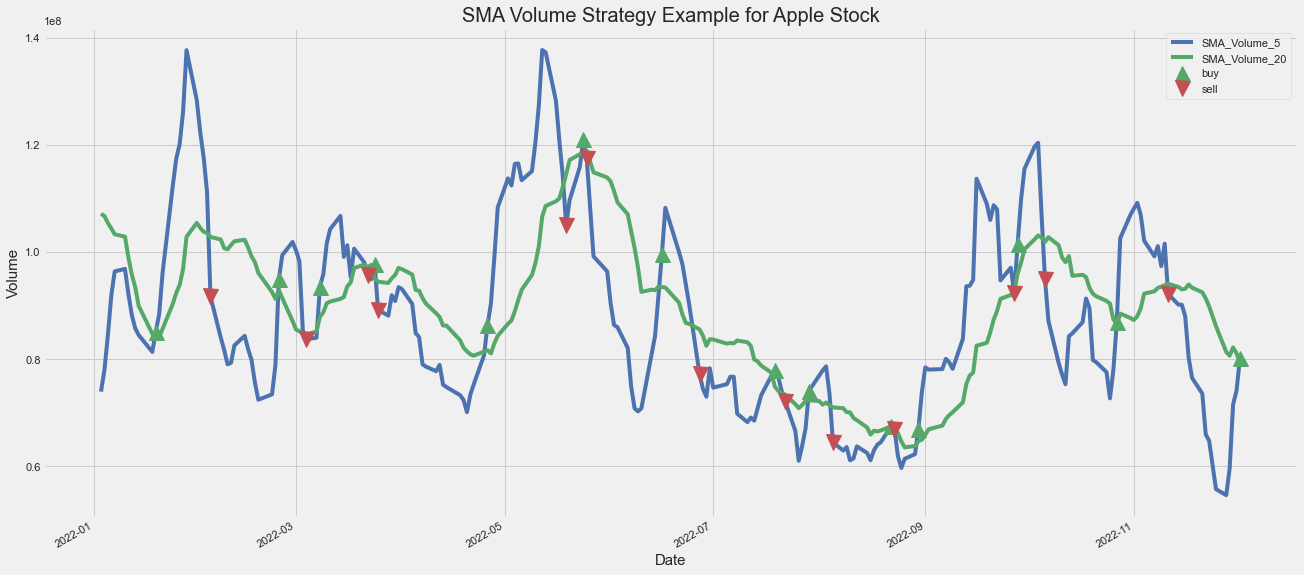

In [7]:
aapl = stocks[stocks['ticker'] == 'AAPL']
aapl = aapl[aapl.index > '2022-01-01']
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
aapl['SMA_Volume_5'].plot(color = 'b',label = 'SMA_Volume_5') 
aapl['SMA_Volume_20'].plot(color = 'g', label = 'SMA_Volume_20')
# plot buy signals
plt.plot(aapl[aapl['SMA_Vol_Indicator_Position'] == 1].index, 
         aapl['SMA_Volume_5'][aapl['SMA_Vol_Indicator_Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot sell signals
plt.plot(aapl[aapl['SMA_Vol_Indicator_Position'] == -1].index, 
         aapl['SMA_Volume_5'][aapl['SMA_Vol_Indicator_Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Volume', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('SMA Volume Strategy Example for Apple Stock', fontsize = 20)
plt.legend()
plt.show()

## Average True Range (ATR)

In [8]:
#ATR is a measure of volatility so we want to exit when there is high volatility 
#Calculate True Range
stocks['TR'] = np.maximum((stocks['High'] - stocks['Low']), 
                     np.maximum(abs(stocks['High'] - stocks['Adj Close'].shift(1)), 
                     abs(stocks['Low'] - stocks['Adj Close'].shift(1))))
#Short term window ATR (1 trading week)
stocks['ATR_5'] = stocks.groupby('ticker')['TR'].transform(lambda x: x.rolling(window = 5).mean())
#Long term window Moving Avg (1 trading month)
stocks['ATR_20'] = stocks.groupby('ticker')['TR'].transform(lambda x: x.rolling(window = 20).mean())
#Check for Inflection and high volatility (when short term ATR crosses above long term), aka: when the ratio < 1
stocks['ATR_Ratio'] = stocks['ATR_20'] / stocks['ATR_5']

#Strategy:
#If ATR_Ratio < 1 THEN BUY
stocks['ATR_Indicator_Action'] = np.where(stocks['ATR_Ratio'] < 1, 1.0,0.0)
stocks['ATR_Indicator_Position'] = stocks['ATR_Indicator_Action'].diff()

### Example Plot

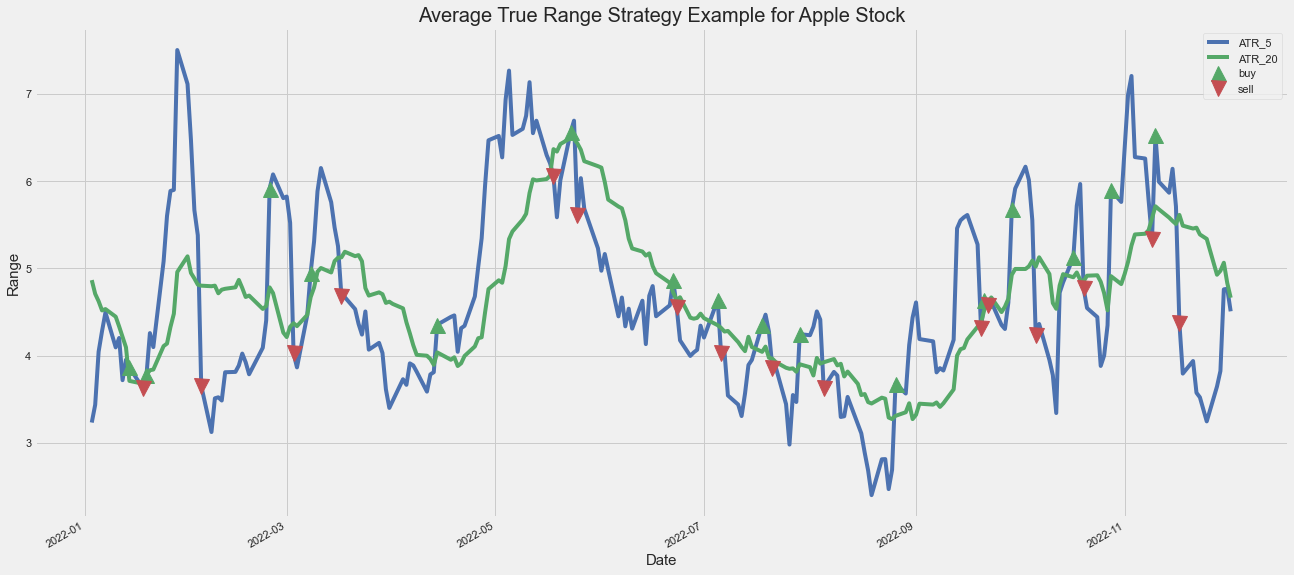

In [9]:
aapl = stocks[stocks['ticker'] == 'AAPL']
aapl = aapl[aapl.index > '2022-01-01']
plt.figure(figsize = (20,10))
# plot ATR ratio, short-term and long-term moving averages 
aapl['ATR_5'].plot(color = 'b',label = 'ATR_5') 
aapl['ATR_20'].plot(color = 'g', label = 'ATR_20')
# plot buy signals
plt.plot(aapl[aapl['ATR_Indicator_Position'] == 1].index, 
         aapl['ATR_5'][aapl['ATR_Indicator_Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot sell signals
plt.plot(aapl[aapl['ATR_Indicator_Position'] == -1].index, 
         aapl['ATR_5'][aapl['ATR_Indicator_Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Range', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Average True Range Strategy Example for Apple Stock', fontsize = 20)
plt.legend()
plt.show()

## Stochastic Oscillators

In [10]:
#Calculate 20 day highs/lows
stocks['20Day_Low'] = stocks.groupby('ticker')['Low'].transform(lambda x: x.rolling(window = 20).min())
stocks['20Day_High'] = stocks.groupby('ticker')['High'].transform(lambda x: x.rolling(window = 20).max())
#Calculate Stochastic Oscillator Formula for %K line
stocks['20Day_%K'] = ((stocks['Adj Close'] - stocks['20Day_Low'])/(stocks['20Day_High'] - stocks['20Day_Low']))*100
#Calculate Stochastic Oscillator Formula for %D line
stocks['20Day_%D'] = stocks['20Day_%K'].rolling(window = 3).mean()

#Strategy:
#If 20Day_%K < 30 AND 20Day_%D < 30 THEN BUY
#If 20Day_%K > 70 AND 20Day_%D > 70 THEN SELL

### Example Plot

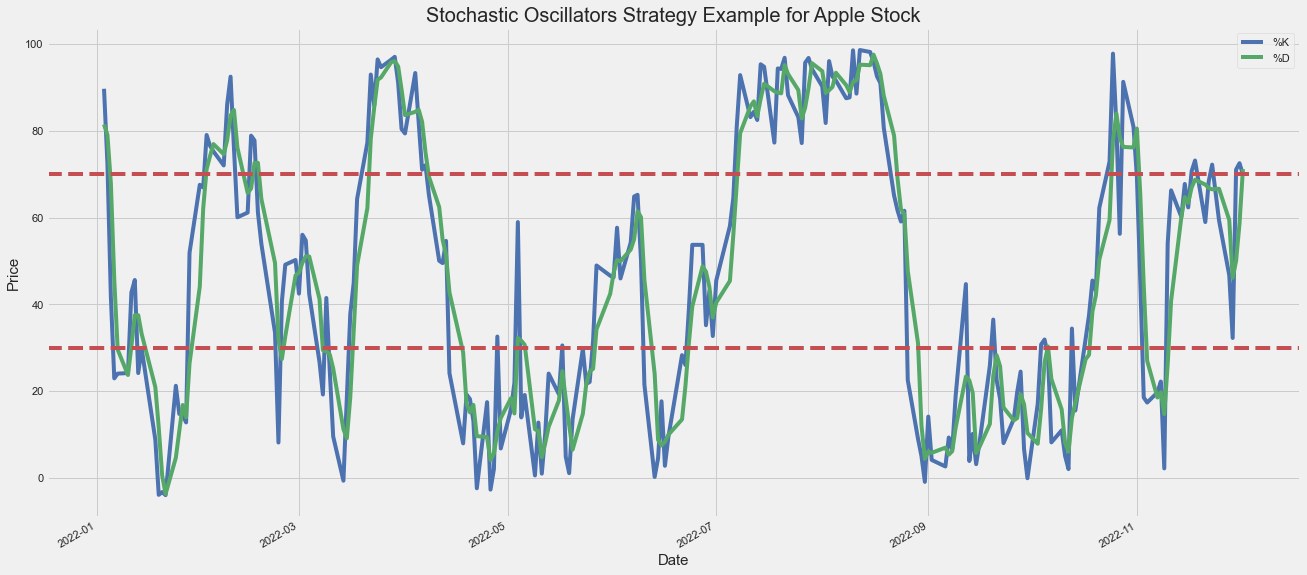

In [11]:
aapl = stocks[stocks['ticker'] == 'AAPL']
aapl = aapl[aapl.index > '2022-01-01']
plt.figure(figsize = (20,10))
# plot adjusted clost, %K and %D lines
aapl['20Day_%K'].plot(color = 'b', label= '%K') 
aapl['20Day_%D'].plot(color = 'g',label = '%D') 

plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Stochastic Oscillators Strategy Example for Apple Stock', fontsize = 20)
plt.axhline(30, linestyle='--', color="r")
plt.axhline(70, linestyle="--", color="r")
plt.legend()
plt.show()

## Relative Strength Index (RSI)

In [12]:
# Calculate gains and losses and averages over 20 day period
stocks['diff'] = stocks.groupby('ticker')['Adj Close'].transform(lambda x: x.diff())
stocks['gain'] = stocks['diff'].clip(lower=0).round(2)
stocks['loss'] = stocks['diff'].clip(upper=0).abs().round(2)
stocks['avg_gain20'] = stocks.groupby('ticker')['gain'].transform(lambda x: x.rolling(window=20).mean())
stocks['avg_loss20'] = stocks.groupby('ticker')['loss'].transform(lambda x: x.rolling(window=20).mean())
#Calculate RS value
stocks['RS_20'] = stocks['avg_gain20'] / stocks['avg_loss20']
#Calculate RSI value
stocks['RSI_20'] = 100 - (100/(1+stocks['RS_20']))

#Strategy:
#If RSI_20 < 30 THEN BUY
#If RSI_20 > 70 THEN SELL

### Example Plot

Text(0.5, 0, 'Date')

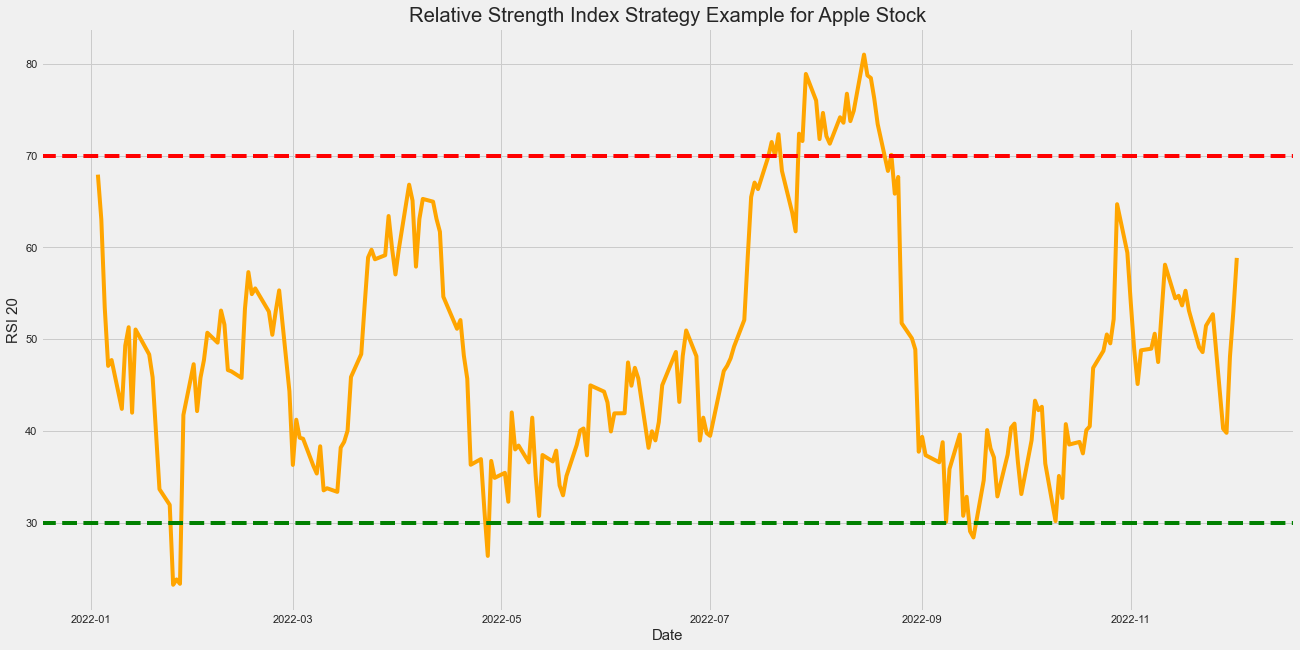

In [13]:
aapl = stocks[stocks['ticker'] == 'AAPL']
aapl = aapl[aapl.index > '2022-01-01']
plt.figure(figsize = (20,10))
# Plot the RSI
plt.title('Relative Strength Index Strategy Example for Apple Stock')
plt.plot(aapl['RSI_20'], color='orange')
# Oversold
plt.axhline(30, linestyle='--', color='green')
# Overbought
plt.axhline(70, linestyle='--', color='red')
plt.ylabel('RSI 20', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )

## Moving Average Convergence Divergence (MACD)

In [14]:
#Calculate 5 and 20 day Exponential Moving Averages
stocks['5Day_EMA'] = stocks.groupby('ticker')['Adj Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
stocks['20Day_EMA'] = stocks.groupby('ticker')['Adj Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
#Calculate MACD Value
stocks['MACD_Value'] = stocks['20Day_EMA'] - stocks['5Day_EMA']
#Calculate 5 day MACD Signal
stocks['MACD_Signal'] = stocks.groupby('ticker')['MACD_Value'].transform(lambda x: x.ewm(span=5, adjust=False).mean())

#Strategy:
#If MACD_Value > MACD_Signal THEN BUY
##If MACD_Signal > MACD_Value THEN SELL
stocks['MACD_Signal_Action'] = np.where(stocks['MACD_Value'] > stocks['MACD_Signal'], 1.0,0.0)
stocks['MACD_Signal_Position'] = stocks['MACD_Signal_Action'].diff()

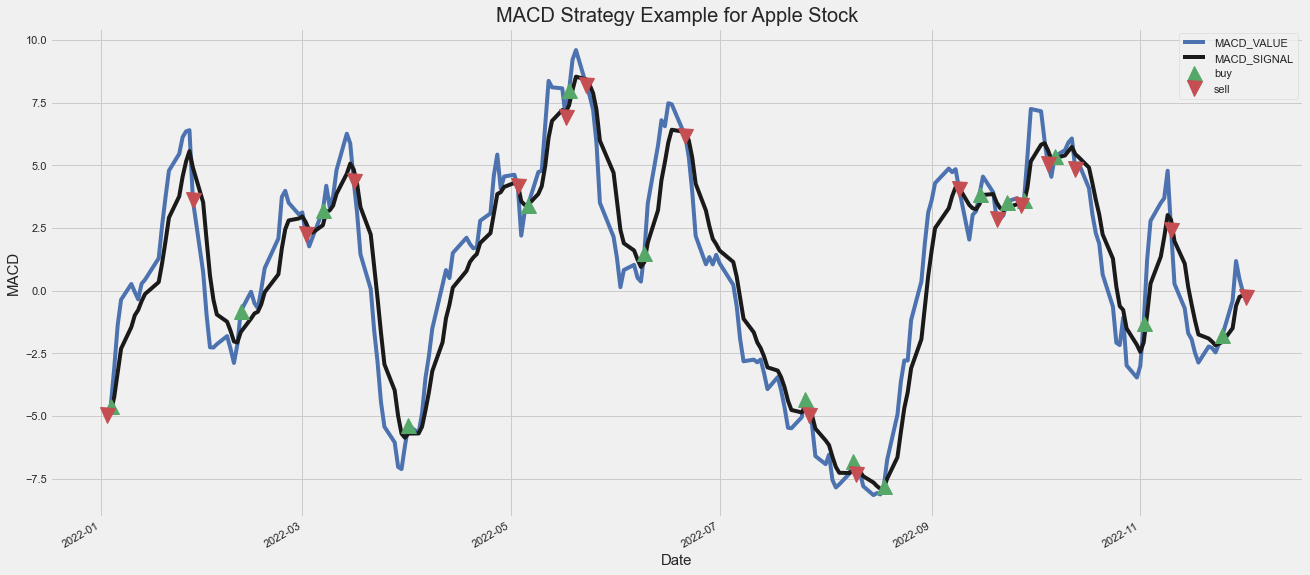

In [15]:
aapl = stocks[stocks['ticker'] == 'AAPL']
aapl = aapl[aapl.index > '2022-01-01']
plt.figure(figsize = (20,10))
# plot RSI line
aapl['MACD_Value'].plot(color = 'b', label= 'MACD_VALUE') 
aapl['MACD_Signal'].plot(color = 'k', label= 'MACD_SIGNAL') 

# plot buy signals
plt.plot(aapl[aapl['MACD_Signal_Position'] == 1].index, 
         aapl['MACD_Value'][aapl['MACD_Signal_Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot sell signals
plt.plot(aapl[aapl['MACD_Signal_Position'] == -1].index, 
         aapl['MACD_Value'][aapl['MACD_Signal_Position']  == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('MACD', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('MACD Strategy Example for Apple Stock', fontsize = 20)
plt.legend()
plt.show()

## Bollinger Bands

In [16]:
#Calculate 20 day moving avg and std 
stocks['SMA_20'] = stocks.groupby('ticker')['Adj Close'].transform(lambda x: x.rolling(window = 20).mean())
stocks['SD_20'] = stocks.groupby('ticker')['Adj Close'].transform(lambda x: x.rolling(window=20).std())
#calculate upper and lower bands 
stocks['upperband'] = stocks['SMA_20'] + 2*stocks['SD_20']
stocks['lowerband'] = stocks['SMA_20'] - 2*stocks['SD_20']

#Strategy:
#If Adj Close > upperband THEN SELL
#If Adj Close < lowerband THEN BUY
stocks['Bollinger_Signal_Action'] = np.where(stocks['lowerband'] > stocks['Adj Close'], 1.0,0.0)
stocks['Bollinger_Signal_Position'] = stocks['Bollinger_Signal_Action'].diff()

### Example Plot

<Figure size 1440x720 with 0 Axes>

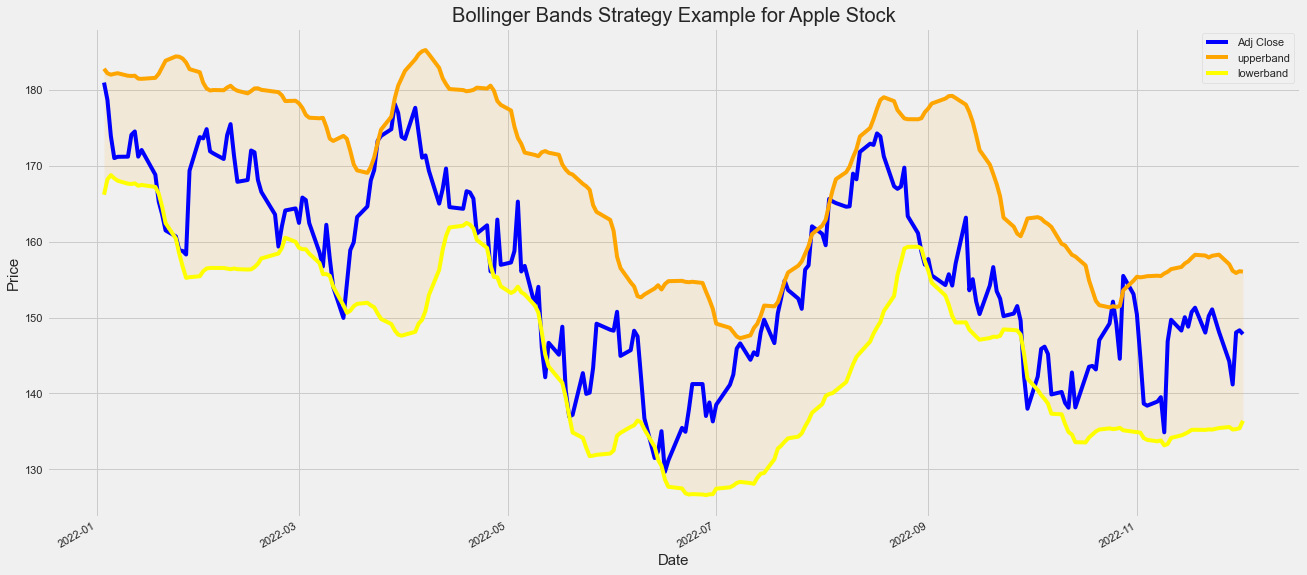

In [17]:
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt

aapl = stocks[stocks['ticker'] == 'AAPL']
aapl = aapl[aapl.index > '2022-01-01']
plt.figure(figsize = (20,10))

ax = aapl[['Adj Close', 'upperband', 'lowerband']].plot(color=['blue', 'orange', 'yellow'])
ax.fill_between(aapl.index, aapl['lowerband'], aapl['upperband'], facecolor='orange', alpha=0.1)
plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Bollinger Bands Strategy Example for Apple Stock', fontsize = 20)
plt.show()

In [18]:
#View complete dataframe
stocks.head(10)

,High,Low,Open,Close,Volume,Adj Close,ticker,returns,SMA_5,SMA_20,...,20Day_EMA,MACD_Value,MACD_Signal,MACD_Signal_Action,MACD_Signal_Position,SD_20,upperband,lowerband,Bollinger_Signal_Action,Bollinger_Signal_Position
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.375000,1.166667,1.312500,1.369792,7226400.0,1.214421,ATVI,NaN,NaN,NaN,...,1.214421,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,0.0,NaN
2000-01-04,1.354167,1.187500,1.343750,1.328125,4262400.0,1.177480,ATVI,-0.030418,NaN,NaN,...,1.210903,0.008795,0.002932,1.0,1.0,NaN,NaN,NaN,0.0,0.0
2000-01-05,1.364583,1.312500,1.317708,1.333333,3390000.0,1.182098,ATVI,0.003921,NaN,NaN,...,1.208160,0.012722,0.006195,1.0,0.0,NaN,NaN,NaN,0.0,0.0
2000-01-06,1.333333,1.296875,1.322917,1.307292,2430000.0,1.159010,ATVI,-0.019531,NaN,NaN,...,1.203479,0.020184,0.010858,1.0,0.0,NaN,NaN,NaN,0.0,0.0
2000-01-07,1.354167,1.291667,1.322917,1.343750,15549600.0,1.191333,ATVI,0.027888,1.184868,NaN,...,1.202322,0.016348,0.012688,1.0,0.0,NaN,NaN,NaN,0.0,0.0
2000-01-10,1.416667,1.322917,1.354167,1.411458,10951200.0,1.251361,ATVI,0.050387,1.192256,NaN,...,1.206992,-0.000778,0.008199,0.0,-1.0,NaN,NaN,NaN,0.0,0.0
2000-01-11,1.520833,1.406250,1.416667,1.473958,10711200.0,1.306772,ATVI,0.044280,1.218115,NaN,...,1.216495,-0.024275,-0.002626,0.0,0.0,NaN,NaN,NaN,0.0,0.0
2000-01-12,1.437500,1.364583,1.437500,1.411458,2689200.0,1.251361,ATVI,-0.042403,1.231967,NaN,...,1.219816,-0.024485,-0.009912,0.0,0.0,NaN,NaN,NaN,0.0,0.0
2000-01-13,1.437500,1.375000,1.406250,1.427083,3267600.0,1.265214,ATVI,0.011070,1.253208,NaN,...,1.224139,-0.027132,-0.015652,0.0,0.0,NaN,NaN,NaN,0.0,0.0


# TRADING STRATEGY

# Method:

- Combination of all Indicators (buy and sell signals)
- All Buy Signals Must be True to buy 
- One Sell Signal Must be True to sell
- Date range (2000-01-01 to present) 
 
- Create a Dataframe with profits and percentage comparisons to SPY buy and hold strategy
- Create a Dataframe with total Profit Gained, Profit Percentage, and SPY Benchmark Profit Comparison for all stocks
- Sort and rank the top 25 stocks to find out what sectors our model predicts best 
- Make a new dataframe with just these sectors 
- Calculate optimal Risk and Weighting for the portfolio 
- Calculate the total profits and final benchmark comparison 

In [19]:
#Create SPY dataframe
df_spy = pd.read_csv('SPY.csv')

#Create function to get benchmark stats using SPY data
def benchmark_stats(starting_date, total_investment_value):
        SPY = df_spy['Adj Close']
        benchmark = pd.DataFrame(np.diff(SPY)).rename(columns = {0:'benchmark_returns'})
        total_stocks = floor(total_investment_value/SPY[0])
        benchmark_investment_return = []

        for i in range(len(benchmark['benchmark_returns'])):
            returns = total_stocks*benchmark['benchmark_returns'][i]
            benchmark_investment_return.append(returns)

        benchmark_investment_return_df = pd.DataFrame(benchmark_investment_return).rename(columns = {0:'investment_returns'})
        return benchmark_investment_return_df

#Choose date and total investment value 
benchmark = benchmark_stats('2000-01-01', 100000)

year = '2000-01-01'
total_investment_value = 100000
total_benchmark_investment_returns = round(sum(benchmark['investment_returns']), 2)
# benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
benchmark_profit_percentage = floor((total_benchmark_investment_returns/total_investment_value)*100)

print('Benchmark Stats from date {} to present day using an inital investment amount of ${}:'.format(year,total_investment_value))
print('Benchmark profit dollar amount ${}'.format(total_benchmark_investment_returns))
print('Benchmark profit percentage amount: {}%'.format(benchmark_profit_percentage))
print()

#Create empty dataframe to hold returns 
returns_df = pd.DataFrame(columns=['Ticker', 'Profit Gained', 'Profit Percentage', 'Benchmark Profit Comparison'])

#loop through all the NASDAQ 100 stocks 
for stock_ticker in stocks.ticker.unique():
    stock = stocks[(stocks['ticker'] == stock_ticker) & (stocks.index > '2000-01-01')]
    
#Create Trading Strategy
    def trading_strategy(prices, SMA_Ratio, SMA_Volume_Ratio, ATR_Ratio, Day20_K, Day20_D, RSI_20, MACD_Value, MACD_Signal, upperband, lowerband):    
        buy_price = []
        sell_price = []
        trading_signal = []
        signal = 0
    #if all of the buy indicator signals are true (Buy)
        for i in range(len(prices)):
            if (SMA_Ratio[i] < 1) & (SMA_Volume_Ratio[i] < 1) & (ATR_Ratio[i] < 1) & (Day20_K[i] < 30) & (Day20_D[i] < 30) \
            & (RSI_20[i] < 30) & (MACD_Value[i] >  MACD_Signal[i]) & (prices[i] < lowerband[i]):
                if signal != 1:
                    buy_price.append(prices[i])
                    sell_price.append(np.nan)
                    signal = 1
                    trading_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    trading_signal.append(0)
    #if any of the sell indicator signals are true (Sell)
            elif (SMA_Ratio[i] > 1) | (SMA_Volume_Ratio[i] > 1) | (ATR_Ratio[i] > 1) | (Day20_K[i] > 70) | (Day20_D[i] > 70) \
            | (RSI_20[i] > 70) | (MACD_Value[i] <  MACD_Signal[i]) | (prices[i] > upperband[i]):
                if signal != -1 and signal != 0:
                    buy_price.append(np.nan)
                    sell_price.append(prices[i])
                    signal = -1
                    trading_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    trading_signal.append(0)

            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                trading_signal.append(0)

        return buy_price, sell_price, trading_signal

    buy_price, sell_price, trading_signal = trading_strategy(stock['Adj Close'], stock['SMA_Ratio'], stock['SMA_Volume_Ratio'],
                                                                       stock['ATR_Ratio'], stock['20Day_%K'], stock['20Day_%D'], stock['RSI_20'],
                                                                       stock['MACD_Value'], stock['MACD_Signal'], stock['upperband'],
                                                                       stock['lowerband'])

#Create Trading Position
    position = []
    for i in range(len(trading_signal)):
        if trading_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)

    for i in range(len(stock['Adj Close'])):
        if trading_signal[i] == 1:
            position[i] = 1
        elif trading_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
    close_price = stock['Adj Close']
    SMA_ratio = stock['SMA_Ratio']
    SMA_Volume_Ratio = stock['SMA_Volume_Ratio']
    ATR_Ratio = stock['ATR_Ratio']
    Day20_K = stock['20Day_%K']
    Day20_D = stock['20Day_%D']
    RSI_20 = stock['RSI_20']
    MACD_Value = stock['MACD_Value']
    MACD_Signal = stock['MACD_Signal']
    upperband = stock['upperband']
    lowerband = stock['lowerband']
    trading_signal = pd.DataFrame(trading_signal).rename(columns = {0:'trading_signal'}).set_index(stock.index)
    position = pd.DataFrame(position).rename(columns = {0:'trading_position'}).set_index(stock.index)

    frames = [close_price, SMA_ratio, SMA_Volume_Ratio, ATR_Ratio, Day20_K, Day20_D, RSI_20, MACD_Value, \
              MACD_Signal, upperband, lowerband, trading_signal, position]
    strategy = pd.concat(frames, join = 'inner', axis = 1)

#Backtest everything
    stock_ret = pd.DataFrame(np.diff(stock['Adj Close'])).rename(columns = {0:'returns'})
    trading_strategy_ret = []

    for i in range(len(stock_ret)):
        try:
            returns = stock_ret['returns'][i] * strategy['trading_position'][i]
            trading_strategy_ret.append(returns)
        except:
            pass

    trading_strategy_ret_df = pd.DataFrame(trading_strategy_ret).rename(columns = {0:'trading_returns'})

    investment_value = 100000
    number_of_stocks = floor(investment_value / stock['Adj Close'][0])
    trading_investment_ret = []

    for i in range(len(trading_strategy_ret_df['trading_returns'])):
        returns = number_of_stocks * trading_strategy_ret_df['trading_returns'][i]
        trading_investment_ret.append(returns)

    trading_investment_ret_df = pd.DataFrame(trading_investment_ret).rename(columns = {0:'investment_returns'})
    total_investment_ret = round(sum(trading_investment_ret_df['investment_returns']), 2)
    profit_percentage = floor((total_investment_ret / investment_value) * 100)
    benchmark_comparison = profit_percentage - benchmark_profit_percentage
#Put everything into a dataframe 
    returns_df = returns_df.append({'Ticker':stock_ticker, 'Profit Gained':total_investment_ret, 'Profit Percentage':profit_percentage, 'Benchmark Profit Comparison': benchmark_comparison}, ignore_index=True)

returns_df

Benchmark Stats from date 2000-01-01 to present day using an inital investment amount of $100000:
Benchmark profit dollar amount $1436591.5
Benchmark profit percentage amount: 1436%



,Ticker,Profit Gained,Profit Percentage,Benchmark Profit Comparison
0,ATVI,6138306.77,6138,4702
1,ADBE,1998368.72,1998,562
2,ADP,953689.85,953,-483
3,ABNB,-30203.61,-31,-1467
4,ALGN,1075594.90,1075,-361
...,...,...,...,...
97,WBA,120974.38,120,-1316
98,WDAY,251081.91,251,-1185
99,XEL,841346.76,841,-595
100,ZM,19843.72,19,-1417


In [20]:
#Add Sector Information for each Ticker
import yfinance as yf
ticker = []
sector = []
for i in returns_df.Ticker.unique():
    ticker.append(i)
    tickerdata = yf.Ticker(i)
    s = tickerdata.info['sector']
    sector.append(s)
sector_df = pd.DataFrame(
    {'Ticker': ticker,
     'Sector': sector})
returns_df = pd.merge(returns_df, sector_df, on='Ticker')
returns_df

,Ticker,Profit Gained,Profit Percentage,Benchmark Profit Comparison,Sector
0,ATVI,6138306.77,6138,4702,Communication Services
1,ADBE,1998368.72,1998,562,Technology
2,ADP,953689.85,953,-483,Industrials
3,ABNB,-30203.61,-31,-1467,Consumer Cyclical
4,ALGN,1075594.90,1075,-361,Healthcare
...,...,...,...,...,...
97,WBA,120974.38,120,-1316,Healthcare
98,WDAY,251081.91,251,-1185,Technology
99,XEL,841346.76,841,-595,Utilities
100,ZM,19843.72,19,-1417,Technology


In [21]:
#Sort the dataframe by profit 
ranked_df = returns_df.sort_values(['Profit Gained'], ascending=False)[:25]

#Print sector value counts
print('Top 25 Performing Sectors: ')
print(ranked_df.Sector[:25].value_counts())
print()
print('Total Inital Sector Counts: ')
print(returns_df.Sector.value_counts())
print()
#Model is best at predicting communication services, make a porfolio of only those companies
print('Ratios to determine true best performing sectors: ')
print('Technology:              (7/39)=', 7/39 )
print('Consumer_Cyclical:       (6/15)=', 6/15)
print('Communication_Services:  (5/13)=', 5/13 )
print('Healthcare:              (5/14)=', 5/14)
print('Industrials:             (1/9)=', 1/9)
print('Consumer Defense:        (1/7)=', 1/7)

Top 25 Performing Sectors: 
Technology                7
Consumer Cyclical         6
Healthcare                5
Communication Services    5
Consumer Defensive        1
Industrials               1
Name: Sector, dtype: int64

Total Inital Sector Counts: 
Technology                39
Consumer Cyclical         15
Healthcare                14
Communication Services    13
Industrials                9
Consumer Defensive         7
Utilities                  4
Financial Services         1
Name: Sector, dtype: int64

Ratios to determine true best performing sectors: 
Technology:              (7/39)= 0.1794871794871795
Consumer_Cyclical:       (6/15)= 0.4
Communication_Services:  (5/13)= 0.38461538461538464
Healthcare:              (5/14)= 0.35714285714285715
Industrials:             (1/9)= 0.1111111111111111
Consumer Defense:        (1/7)= 0.14285714285714285


In [22]:
#Best pertforming sectors were by far Communication Services and Healthcare
#Create a new portfolio with only Communication Services and Healthcare Stocks from the NASDAQ 100
portfolio_df = returns_df[(returns_df.Sector == 'Communication Services') | (returns_df.Sector == 'Healthcare')]
portfolio_df

,Ticker,Profit Gained,Profit Percentage,Benchmark Profit Comparison,Sector
0,ATVI,6138306.77,6138,4702,Communication Services
4,ALGN,1075594.90,1075,-361,Healthcare
5,GOOGL,3899924.16,3899,2463,Communication Services
6,GOOG,3934513.05,3934,2498,Communication Services
10,AMGN,505025.01,505,-931,Healthcare
16,AZN,679264.67,679,-757,Healthcare
19,BIDU,828615.39,828,-608,Communication Services
20,BIIB,861566.20,861,-575,Healthcare
24,CHTR,1021920.34,1021,-415,Communication Services
28,CMCSA,204602.67,204,-1232,Communication Services


Text(0.5, 1.0, 'Efficient Frontier')

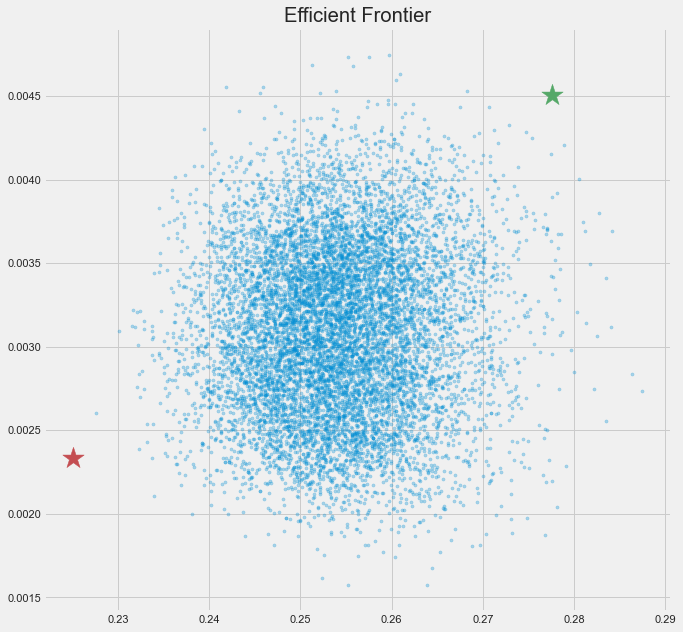

In [28]:
#Portfolio Risk, Weighting Calculations

portfolio_tickers = list(portfolio_df.Ticker.unique())
risk_df = stocks[(stocks.ticker.isin(portfolio_tickers)) & (stocks.index >= '2020-01-01')]

stocks_min_risk = risk_df[['ticker','Adj Close']]
stocks_min_risk = pd.pivot(stocks_min_risk,columns = 'ticker', values = 'Adj Close')

cov_matrix = stocks_min_risk.pct_change().apply(lambda x: np.log(1+x)).cov()
corr_matrix = stocks_min_risk.pct_change().apply(lambda x: np.log(1+x)).corr()


# weekly returns for individual companies
ind_er = stocks_min_risk.resample('W').last().pct_change().mean()


p_ret = [] # portfolio returns
p_vol = [] # portfolio volatility
p_weights = [] # asset weights

num_assets = len(stocks_min_risk.columns)
num_portfolios = 10000


for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er)    
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250) 
    p_vol.append(ann_sd)

data1 = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(stocks_min_risk.columns.tolist()):
    data1[symbol+' weight'] = [w[counter] for w in p_weights]
portfolios  = pd.DataFrame(data1)
portfolios.head()

min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
               
rf = 0.01 
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]

plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)
plt.title("Efficient Frontier")

In [29]:
#Minimum Volatility Weight
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]

# Maximum Return Weight
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
print('Maximum Return Weight: ')
print(optimal_risky_port)

Maximum Return Weight: 
Returns         0.004506
Volatility      0.277543
ALGN weight     0.090145
AMGN weight     0.028277
ATVI weight     0.016915
AZN weight      0.037044
BIDU weight     0.007452
BIIB weight     0.051789
CHTR weight     0.035955
CMCSA weight    0.009774
DXCM weight     0.071697
EA weight       0.021832
GILD weight     0.029272
GOOG weight     0.076967
GOOGL weight    0.002175
IDXX weight     0.014059
ILMN weight     0.003982
ISRG weight     0.050794
META weight     0.030557
MRNA weight     0.097013
MTCH weight     0.067667
NFLX weight     0.001624
NTES weight     0.087154
REGN weight     0.044310
SGEN weight     0.028609
SIRI weight     0.068213
TMUS weight     0.001451
VRTX weight     0.020747
WBA weight      0.004526
Name: 5373, dtype: float64


In [30]:
#Add weights to final portfolio
portfolio_df = portfolio_df.sort_values('Ticker')
ticker_list = list(portfolio_df.Ticker)
weight_list = list(optimal_risky_port[2:])
weight_dict = dict(zip(ticker_list, weight_list))
weight_df = pd.DataFrame(weight_dict.items(), columns=['Ticker', 'Weight'])
final_portfolio_df = pd.merge(portfolio_df, weight_df, on='Ticker', how='outer')
final_portfolio_df

,Ticker,Profit Gained,Profit Percentage,Benchmark Profit Comparison,Sector,Weight
0,ALGN,1075594.90,1075,-361,Healthcare,0.090145
1,AMGN,505025.01,505,-931,Healthcare,0.028277
2,ATVI,6138306.77,6138,4702,Communication Services,0.016915
3,AZN,679264.67,679,-757,Healthcare,0.037044
4,BIDU,828615.39,828,-608,Communication Services,0.007452
5,BIIB,861566.20,861,-575,Healthcare,0.051789
6,CHTR,1021920.34,1021,-415,Communication Services,0.035955
7,CMCSA,204602.67,204,-1232,Communication Services,0.009774
8,DXCM,3924127.45,3924,2488,Healthcare,0.071697
9,EA,429794.10,429,-1007,Communication Services,0.021832


In [31]:
#Multiply weights by profit statistics 
final_portfolio_df['Profit Gained'] = final_portfolio_df['Profit Gained'] * final_portfolio_df['Weight']
final_portfolio_df['Profit Percentage'] = final_portfolio_df['Profit Percentage'] * final_portfolio_df['Weight']
final_portfolio_df['Benchmark Profit Comparison'] = final_portfolio_df['Benchmark Profit Comparison'] * final_portfolio_df['Weight']
final_portfolio_df

,Ticker,Profit Gained,Profit Percentage,Benchmark Profit Comparison,Sector,Weight
0,ALGN,9.695951e+04,96.905886,-32.542349,Healthcare,0.090145
1,AMGN,1.428067e+04,14.279966,-26.326036,Healthcare,0.028277
2,ATVI,1.038292e+05,103.824012,79.534132,Communication Services,0.016915
3,AZN,2.516283e+04,25.153024,-28.042473,Healthcare,0.037044
4,BIDU,6.174839e+03,6.170254,-4.530814,Communication Services,0.007452
5,BIIB,4.461936e+04,44.590036,-29.778479,Healthcare,0.051789
6,CHTR,3.674305e+04,36.709958,-14.921285,Communication Services,0.035955
7,CMCSA,1.999861e+03,1.99397,-12.042016,Communication Services,0.009774
8,DXCM,2.813475e+05,281.338398,178.381737,Healthcare,0.071697
9,EA,9.383282e+03,9.365945,-21.984864,Communication Services,0.021832


In [32]:
#Calculate Total Benchmark Profit Comparison of our Final weighted portfolio 
print('Our trading strategy outperformed a buy and hold SPY strategy over the years 2000-01-01 to present day by', round(final_portfolio_df['Benchmark Profit Comparison'].sum(),2), '%')

Our trading strategy outperformed a buy and hold SPY strategy over the years 2000-01-01 to present day by 2235.51 %
